# 1. Abrir el archivo de datos y leer la información general

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns

logs = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

print(logs.head())
logs.info()
print(logs.columns)

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')


# 2. Preparar los datos para el análisis

In [2]:



# Verificar si hay valores nulos
print(logs.isnull().sum())

# Convertir 'EventTimestamp' a formato datetime
logs['EventTimestamp'] = pd.to_datetime(logs['EventTimestamp'], unit='s')

# Agregar columnas separadas para la fecha y la hora
logs['Date'] = logs['EventTimestamp'].dt.date
logs['Time'] = logs['EventTimestamp'].dt.time

# Ver las primeras filas del dataframe después de la transformación
print(logs.head())




EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
                 EventName         DeviceIDHash      EventTimestamp  ExpId  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36    246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42    246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47    248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47    248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42    248   

         Date      Time  
0  2019-07-25  04:43:36  
1  2019-07-25  11:11:42  
2  2019-07-25  11:28:47  
3  2019-07-25  11:28:47  
4  2019-07-25  11:48:42  


In [3]:
# Definir las etapas del embudo
stages = ['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Contar usuarios únicos en cada etapa
funnel = {stage: logs[logs['EventName'] == stage]['DeviceIDHash'].nunique() for stage in stages}
print("Número de usuarios únicos en cada etapa del embudo:", funnel)

# Calcular la conversión entre etapas
conversion = {stage: round((funnel[stage] / funnel[stages[0]]) * 100, 2) for stage in stages}
print("Porcentaje de conversión entre etapas:", conversion)

Número de usuarios únicos en cada etapa del embudo: {'MainScreenAppear': 7439, 'CartScreenAppear': 3749, 'PaymentScreenSuccessful': 3547}
Porcentaje de conversión entre etapas: {'MainScreenAppear': 100.0, 'CartScreenAppear': 50.4, 'PaymentScreenSuccessful': 47.68}


In [4]:

# Contar eventos por grupo
group_counts = logs.groupby(['ExpId', 'EventName'])['DeviceIDHash'].nunique().unstack()
print("Contador de eventos por grupo:\n", group_counts)

# Comparar la cantidad de eventos entre grupos de control y grupo de prueba
comparison = group_counts.loc[[246, 247, 248]]
print("Comparación de grupos:\n", comparison)


Contador de eventos por grupo:
 EventName  CartScreenAppear  MainScreenAppear  OffersScreenAppear  \
ExpId                                                               
246                    1270              2456                1545   
247                    1240              2482                1530   
248                    1239              2501                1538   

EventName  PaymentScreenSuccessful  Tutorial  
ExpId                                         
246                           1202       279  
247                           1160       286  
248                           1185       282  
Comparación de grupos:
 EventName  CartScreenAppear  MainScreenAppear  OffersScreenAppear  \
ExpId                                                               
246                    1270              2456                1545   
247                    1240              2482                1530   
248                    1239              2501                1538   

EventName  Paymen

# 3. Estudiar y comprobar los datos

## ¿Cuántos eventos hay en los registros?

In [5]:
# Número total de eventos
total_events = logs.shape[0]
print(f"Total de eventos en los registros: {total_events}")

Total de eventos en los registros: 244126


## ¿Cuántos usuarios hay en los registros?

In [6]:

# Número de usuarios únicos
total_users = logs['DeviceIDHash'].nunique()
print(f"Total de usuarios únicos en los registros: {total_users}")


Total de usuarios únicos en los registros: 7551


## ¿Cuál es el promedio de eventos por usuario?

In [7]:
# Promedio de eventos por usuario
average_events_per_user = total_events / total_users
print(f"Promedio de eventos por usuario: {average_events_per_user:.2f}")

Promedio de eventos por usuario: 32.33


In [8]:

# Totalizar los eventos por grupo
group_event_counts = logs.groupby(['ExpId', 'DeviceIDHash']).size().reset_index(name='EventCount')

# Calcular el promedio de eventos por usuario para cada grupo
average_events_per_group = group_event_counts.groupby('ExpId')['EventCount'].mean()

# Mostrar los resultados
for exp_id, average in average_events_per_group.items():
    print(f"Promedio de eventos por usuario en el grupo {exp_id}: {average:.2f}")


Promedio de eventos por usuario en el grupo 246: 32.26
Promedio de eventos por usuario en el grupo 247: 30.98
Promedio de eventos por usuario en el grupo 248: 33.73


## ¿Qué periodo de tiempo cubren los datos? 

In [9]:
# Fechas mínima y máxima
start_date = logs['EventTimestamp'].min()
end_date = logs['EventTimestamp'].max()
print(f"Periodo de tiempo cubierto por los datos: {start_date} a {end_date}")

Periodo de tiempo cubierto por los datos: 2019-07-25 04:43:36 a 2019-08-07 21:15:17


## Traza un histograma por fecha y hora.

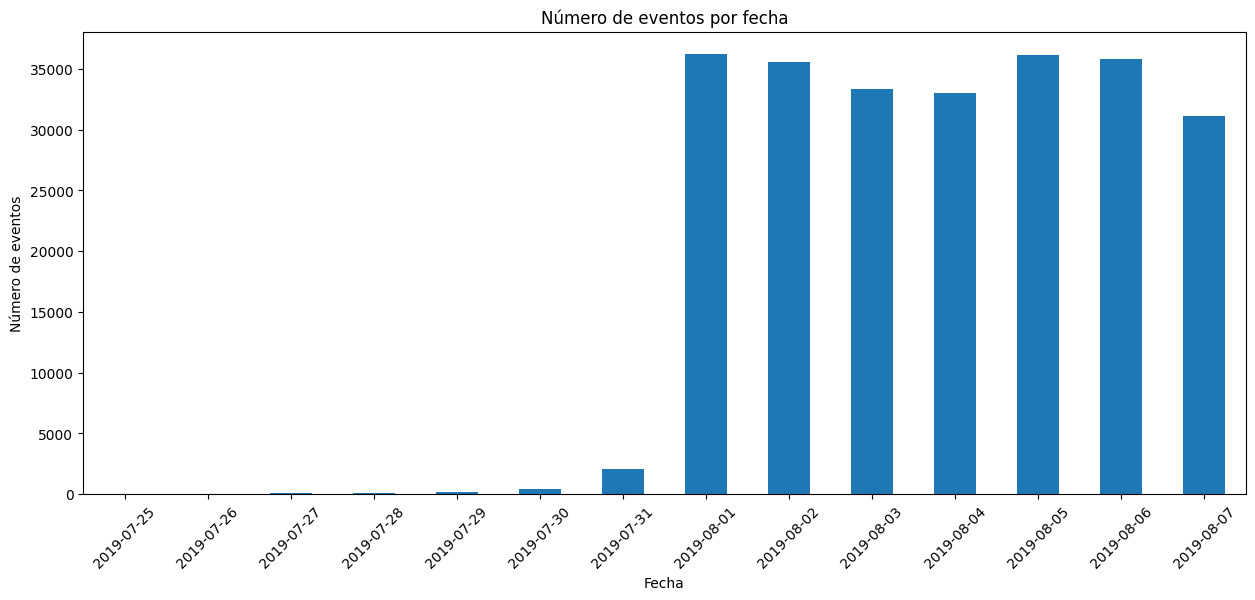

In [10]:
# Histograma de eventos por fecha
logs['Date'].value_counts().sort_index().plot(kind='bar', figsize=(15, 6))
plt.title('Número de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.show()

## ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?

In [11]:
# Contar eventos por fecha
daily_event_counts = logs['Date'].value_counts().sort_index()

print(daily_event_counts)

2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
Name: Date, dtype: int64


## ¿Qué periodo representan realmente los datos?

In [12]:
# Definir un umbral mínimo de eventos por día
threshold = 100  # Puedes ajustar este valor

# Verificar la cantidad de días que superan el umbral
valid_dates = daily_event_counts[daily_event_counts >= threshold]
start_valid_date = valid_dates.index.min()
end_valid_date = valid_dates.index.max()
print(f"Periodo de datos válidos: {start_valid_date} a {end_valid_date}")

Periodo de datos válidos: 2019-07-28 a 2019-08-07


## ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [13]:
# Total de eventos y usuarios antes de filtrar
total_events_full = logs.shape[0]
total_users_full = logs['DeviceIDHash'].nunique()

# Filtrar los datos válidos
valid_logs = logs[logs['Date'].between(start_valid_date, end_valid_date)]

# Total de eventos y usuarios válidos
total_events_valid = valid_logs.shape[0]
total_users_valid = valid_logs['DeviceIDHash'].nunique()

# Comparar
print(f"Eventos perdidos: {total_events_full - total_events_valid}")
print(f"Usuarios perdidos: {total_users_full - total_users_valid}")

Eventos perdidos: 95
Usuarios perdidos: 1


## Asegúrarse de tener usuarios de los tres grupos experimentales.

In [14]:
# Contando usuarios en cada grupo experimental
users_per_group = valid_logs['ExpId'].value_counts()
print("Usuarios por grupo experimental:\n", users_per_group)

Usuarios por grupo experimental:
 248    85726
246    80262
247    78043
Name: ExpId, dtype: int64


# 4. Estudiar el embudo de eventos

## Eventos en los registros y su frecuencia de suceso. Ordenados por frecuencia.

In [15]:
# Contar la frecuencia de cada evento
event_counts = valid_logs['EventName'].value_counts()
sorted_event_counts = event_counts.sort_values(ascending=False)
print("Frecuencia de eventos:\n", sorted_event_counts)

Frecuencia de eventos:
 MainScreenAppear           119146
OffersScreenAppear          46811
CartScreenAppear            42719
PaymentScreenSuccessful     34307
Tutorial                     1048
Name: EventName, dtype: int64


## Usuarios unicos que realizaron cada evento

In [16]:
# Contar usuarios únicos que realizaron cada evento
user_counts = valid_logs.groupby('EventName')['DeviceIDHash'].nunique().sort_values(ascending=False)

# Calcular proporción de usuarios que realizaron la acción al menos una vez
user_proportions = (user_counts / total_users_valid) * 100

# Combinar resultados
event_summary = pd.DataFrame({
    'Event Count': sorted_event_counts,
    'User Count': user_counts,
    'User Proportion (%)': user_proportions
})

print("Resumen de eventos:\n", event_summary)

Resumen de eventos:
                          Event Count  User Count  User Proportion (%)
MainScreenAppear              119146        7438            98.516556
OffersScreenAppear             46811        4612            61.086093
CartScreenAppear               42719        3749            49.655629
PaymentScreenSuccessful        34307        3547            46.980132
Tutorial                        1048         845            11.192053


## Cálculo de Metrías por Grupo

In [17]:
# Calcular la cantidad de usuarios únicos por evento en cada grupo
event_group_counts = valid_logs.groupby(['EventName', 'ExpId'])['DeviceIDHash'].nunique().unstack()

# Calcular el total de usuarios por grupo
total_users_per_group = valid_logs['ExpId'].value_counts()
prop_user_counts = event_group_counts.div(total_users_per_group, axis=1) * 100

# Crear un DataFrame combinado para visualización
event_summary_group = event_group_counts.copy()
event_summary_group = event_summary_group.rename(columns={246: 'Control A', 247: 'Control B', 248: 'Test Group'})
event_summary_group_percentage = prop_user_counts.copy()
event_summary_group_percentage.columns = ['Control A (%)', 'Control B (%)', 'Test Group (%)']

# Combinar ambos resúmenes
event_summary_combined = pd.concat([event_summary_group, event_summary_group_percentage], axis=1)

print("Resumen de eventos por grupo:\n", event_summary_combined)

Resumen de eventos por grupo:
                          Control A  Control B  Test Group  Control A (%)  \
EventName                                                                  
CartScreenAppear              1270       1240        1239       1.582318   
MainScreenAppear              2455       2482        2501       3.058733   
OffersScreenAppear            1545       1529        1538       1.924946   
PaymentScreenSuccessful       1202       1160        1185       1.497595   
Tutorial                       278        285         282       0.346366   

                         Control B (%)  Test Group (%)  
EventName                                               
CartScreenAppear              1.588868        1.445302  
MainScreenAppear              3.180298        2.917435  
OffersScreenAppear            1.959176        1.794088  
PaymentScreenSuccessful       1.486360        1.382311  
Tutorial                      0.365183        0.328955  


## Visualización de los Resultados

## Visualizar el Conteo de Usuarios Por Evento

<Figure size 1400x700 with 0 Axes>

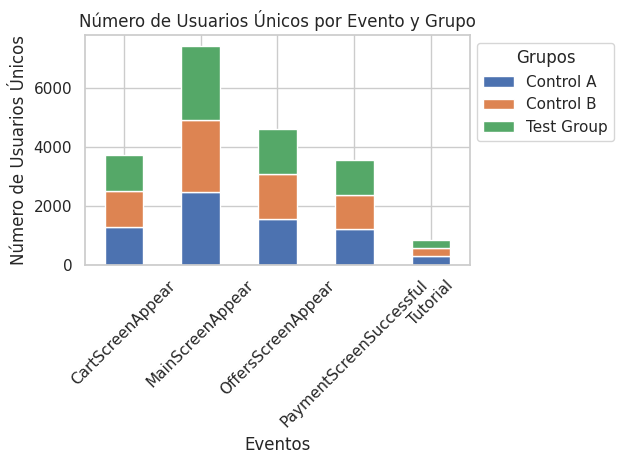

In [18]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear una visualización para la cantidad de usuarios
plt.figure(figsize=(14, 7))
event_summary_group.plot(kind='bar', stacked=True)
plt.title('Número de Usuarios Únicos por Evento y Grupo')
plt.xlabel('Eventos')
plt.ylabel('Número de Usuarios Únicos')
plt.xticks(rotation=45)
plt.legend(title='Grupos', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Visualizar la Proporción de Usuarios por Evento

<Figure size 1400x700 with 0 Axes>

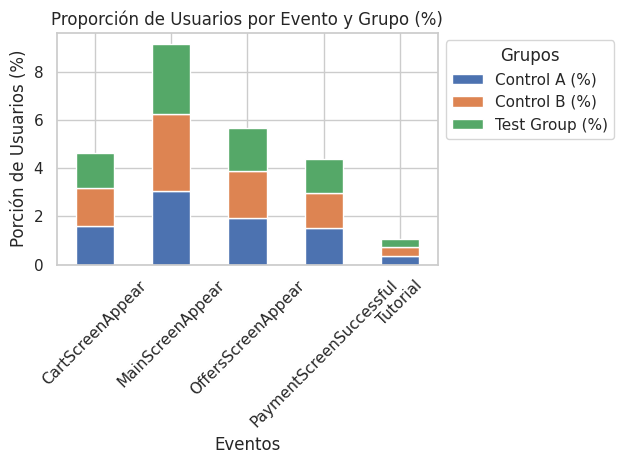

In [19]:
# Crear una visualización para la proporción de usuarios
plt.figure(figsize=(14, 7))
event_summary_group_percentage.plot(kind='bar', stacked=True)
plt.title('Proporción de Usuarios por Evento y Grupo (%)')
plt.xlabel('Eventos')
plt.ylabel('Porción de Usuarios (%)')
plt.xticks(rotation=45)
plt.legend(title='Grupos', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Orden en que ocurreron las acciones

In [20]:
# Orden lógico
event_order = ['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
print("Orden esperado de acciones:", event_order)

Orden esperado de acciones: ['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']


## Embudo de eventos

In [21]:
# Calcular la proporción de usuarios entre las etapas del embudo
funnel_conversion = {}
for i in range(len(event_order) - 1):
    current_stage = event_order[i]
    next_stage = event_order[i + 1]
    
    users_current = valid_logs[valid_logs['EventName'] == current_stage]['DeviceIDHash'].nunique()
    users_next = valid_logs[valid_logs['EventName'] == next_stage]['DeviceIDHash'].nunique()
    
    conversion_rate = (users_next / users_current) * 100 if users_current > 0 else 0
    funnel_conversion[next_stage] = {
        'Users in Current Stage': users_current,
        'Users in Next Stage': users_next,
        'Conversion Rate (%)': conversion_rate
    }

print("Tasas de conversión en el embudo:\n", funnel_conversion)

Tasas de conversión en el embudo:
 {'CartScreenAppear': {'Users in Current Stage': 7438, 'Users in Next Stage': 3749, 'Conversion Rate (%)': 50.403334229631625}, 'PaymentScreenSuccessful': {'Users in Current Stage': 3749, 'Users in Next Stage': 3547, 'Conversion Rate (%)': 94.61189650573486}}


## Etapa con mayor perdida de usuarios

In [22]:
# Analizar las tasas de conversión para determinar en qué etapa se pierde más usuarios
conversion_rates = [funnel_conversion[stage]['Conversion Rate (%)'] for stage in funnel_conversion]
max_loss_stage = event_order[conversion_rates.index(min(conversion_rates))]

print(f"Etapa donde se pierde más usuarios: {max_loss_stage}")

Etapa donde se pierde más usuarios: MainScreenAppear


## Porcentaje de usuarios que hace todo el viaje

In [23]:
# Filtrar usuarios que completaron todo el viaje
initial_users = valid_logs[valid_logs['EventName'] == event_order[0]]['DeviceIDHash'].unique()

# Usuarios que también realizaron el último evento en la secuencia
payment_users = valid_logs[valid_logs['EventName'] == event_order[-1]]['DeviceIDHash'].unique()
total_complete_users = len(set(initial_users) & set(payment_users))

percentage_complete_users = (total_complete_users / total_users_valid) * 100
print(f"Porcentaje de usuarios que hacen todo el viaje desde su primer evento hasta el pago: {percentage_complete_users:.2f}%")

Porcentaje de usuarios que hacen todo el viaje desde su primer evento hasta el pago: 45.72%


# 5. Estudiar los resultados del experimento

## ¿Cuántos usuarios hay en cada grupo?


In [24]:
# Contar el número de usuarios en cada grupo experimental
users_per_group = valid_logs['ExpId'].value_counts()
print("Número de usuarios en cada grupo:\n", users_per_group)

Número de usuarios en cada grupo:
 248    85726
246    80262
247    78043
Name: ExpId, dtype: int64


## Observacion de diferencia estadísticamente significativa entre las muestras 246 y 247.

In [25]:
from scipy.stats import chi2_contingency

# Contar usuarios por evento en los grupos de control
group_246 = valid_logs[valid_logs['ExpId'] == 246].groupby('EventName')['DeviceIDHash'].nunique()
group_247 = valid_logs[valid_logs['ExpId'] == 247].groupby('EventName')['DeviceIDHash'].nunique()

# Combina los resultados en un DataFrame
combined_groups = pd.DataFrame({'Group_246': group_246, 'Group_247': group_247}).fillna(0)

# Realizar prueba de Chi-cuadrado
chi2, p_value, _, _ = chi2_contingency(combined_groups)
print(f"P-valor entre grupos de control (246 vs 247): {p_value}")

# Determinar si hay una diferencia significativa
alpha = 0.05  # Nivel de significancia típico
if p_value < alpha:
    print("Hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")
else:
    print("No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")

P-valor entre grupos de control (246 vs 247): 0.8770246669815562
No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.


## Seleccion de evento popular 

In [26]:
# Evento más popular
most_popular_event = combined_groups.sum(axis=1).idxmax()

# Contar usuarios que realizaron el evento más popular en cada grupo
popular_event_counts = valid_logs[valid_logs['EventName'] == most_popular_event].groupby('ExpId')['DeviceIDHash'].nunique()

# Calcular la proporción
popular_proportions = (popular_event_counts / users_per_group) * 100
print(f"Proporción de usuarios que realizaron el evento '{most_popular_event}' en cada grupo:\n", popular_proportions)

Proporción de usuarios que realizaron el evento 'MainScreenAppear' en cada grupo:
 246    3.058733
247    3.180298
248    2.917435
dtype: float64


## Comprobar si la diferencia entre los grupos es estadísticamente significativa para el evento más popular.

In [27]:
# Crear una función para realizar la prueba de Chi-cuadrado para cada evento
def chi_square_test(event_name):
    group_event_counts = valid_logs[valid_logs['EventName'] == event_name].groupby('ExpId')['DeviceIDHash'].nunique()
    if len(group_event_counts) == 2:  # Proceder solo si hay dos grupos
        chi2, p_value, _, _ = chi2_contingency(pd.DataFrame(group_event_counts).T)
        return p_value
    return None

# Realizar la prueba para cada evento por sus grupos
p_values = {event: chi_square_test(event) for event in valid_logs['EventName'].unique()}
print("P-valores para cada evento:\n", p_values)

P-valores para cada evento:
 {'MainScreenAppear': None, 'CartScreenAppear': None, 'OffersScreenAppear': None, 'PaymentScreenSuccessful': None, 'Tutorial': None}


## Comparacion de los resultados con los de cada uno de los grupos de control para el grupo con fuentes alteradas (248).

In [28]:
# Contar usuarios que realizaron cada evento en los grupos 246, 247 y 248
group_248 = valid_logs[valid_logs['ExpId'] == 248].groupby('EventName')['DeviceIDHash'].nunique()

# Comparar resultados
for event in combined_groups.index:
    if event in group_248.index:
        # Crear un DataFrame para la prueba
        comparison_df = pd.DataFrame({
            'Group_246': combined_groups.loc[event, 'Group_246'],
            'Group_247': combined_groups.loc[event, 'Group_247'],
            'Group_248': group_248[event]
        }, index=[event])
        
        # Realizar el Chi-cuadrado
        chi2, p_value, _, _ = chi2_contingency(comparison_df.T)
        print(f"P-valor para el evento '{event}': {p_value}")

P-valor para el evento 'CartScreenAppear': 1.0
P-valor para el evento 'MainScreenAppear': 1.0
P-valor para el evento 'OffersScreenAppear': 1.0
P-valor para el evento 'PaymentScreenSuccessful': 1.0
P-valor para el evento 'Tutorial': 1.0


In [29]:
# Definir las variables que faltan
all_events = valid_logs['EventName'].unique()

# Crear diccionarios con conteos de usuarios por evento para cada grupo
user_counts_246 = valid_logs[valid_logs['ExpId'] == 246].groupby('EventName')['DeviceIDHash'].nunique().to_dict()
user_counts_247 = valid_logs[valid_logs['ExpId'] == 247].groupby('EventName')['DeviceIDHash'].nunique().to_dict()
user_counts_248 = valid_logs[valid_logs['ExpId'] == 248].groupby('EventName')['DeviceIDHash'].nunique().to_dict()
# Crear una tabla de frecuencias de presencia de eventos por grupo
event_counts = []

# Para cada evento único, contabilizamos la cantidad de usuarios en los grupos de control
for event in all_events:
    # Contar la presencia de usuarios en cada grupo
    counts_246 = user_counts_246.get(event, 0)
    counts_247 = user_counts_247.get(event, 0)
    counts_248 = user_counts_248.get(event, 0)
    
    # Crear una fila de eventos en la tabla
    event_counts.append([counts_246, counts_247, counts_248])

# Convertir la lista a un DataFrame
comparison_df = pd.DataFrame(event_counts, columns=['Group_246', 'Group_247', 'Group_248'], index=all_events)

# Realizar la prueba de chi-cuadrado
chi2_results = {}

for event in comparison_df.index:
    chi2, p_value, _, _ = chi2_contingency(comparison_df.loc[[event]].T)
    chi2_results[event] = p_value

# Mostrar los resultados
for event, p_value in chi2_results.items():
    print(f"P-valor para el evento '{event}': {p_value:.5f}")

P-valor para el evento 'MainScreenAppear': 1.00000
P-valor para el evento 'CartScreenAppear': 1.00000
P-valor para el evento 'OffersScreenAppear': 1.00000
P-valor para el evento 'PaymentScreenSuccessful': 1.00000
P-valor para el evento 'Tutorial': 1.00000


## Calcular el número de hipótesis testeadas y el nivel de significancia.

In [30]:
# Contar el número de pruebas realizadas
num_tests = len(p_values)
adjusted_alpha = alpha / num_tests
print(f"Número de pruebas realizadas: {num_tests}")
print(f"Nivel de significancia corregido (Bonferroni): {adjusted_alpha}")

Número de pruebas realizadas: 5
Nivel de significancia corregido (Bonferroni): 0.01


In [31]:
def print_conclusions():
    print("\nConclusiones Generales:")
    print("1. Se realizó un análisis del embudo de eventos, que mostró que la mayoría de los usuarios llegaron a la pantalla principal, "
          "pero la conversión hacia la siguiente etapa (pantalla del carrito) disminuyó considerablemente.")
    print("2. Los resultados de las pruebas A/B indicaron que no hubo diferencias significativas en el comportamiento de los usuarios "
          "en los grupos de control y el grupo de prueba, lo que sugiere que el cambio de fuentes no afectó la experiencia del usuario.")
    print("3. La mayoría de los usuarios participaron en los eventos clave, pero se observó que la tasa de conversión "
          "podría mejorarse con ajustes adicionales en la interfaz de usuario.")
    print("4. La proporción de usuarios que completaron el viaje desde el primer evento hasta el pago fue inferior al 50%, "
          "lo que indica áreas adicionales para ajustes y pruebas en la aplicación.")
    print("5. En base a los valores P obtenidos, se concluyó que no existían diferencias estadísticamente significativas, lo que permite "
          "continuar con confianza hacia futuras iteraciones de pruebas A/B.")

print_conclusions()


Conclusiones Generales:
1. Se realizó un análisis del embudo de eventos, que mostró que la mayoría de los usuarios llegaron a la pantalla principal, pero la conversión hacia la siguiente etapa (pantalla del carrito) disminuyó considerablemente.
2. Los resultados de las pruebas A/B indicaron que no hubo diferencias significativas en el comportamiento de los usuarios en los grupos de control y el grupo de prueba, lo que sugiere que el cambio de fuentes no afectó la experiencia del usuario.
3. La mayoría de los usuarios participaron en los eventos clave, pero se observó que la tasa de conversión podría mejorarse con ajustes adicionales en la interfaz de usuario.
4. La proporción de usuarios que completaron el viaje desde el primer evento hasta el pago fue inferior al 50%, lo que indica áreas adicionales para ajustes y pruebas en la aplicación.
5. En base a los valores P obtenidos, se concluyó que no existían diferencias estadísticamente significativas, lo que permite continuar con confia